# TORCHMETRICS

## Librerias

In [ ]:
!pip install torch torchmetrics torch-fidelity &> /dev/null

Descomprimir datos reales para compararlos

In [ ]:
# Constantes
RUTA_DATOS='/content/'                    # Carpeta de trabajo
# Ingresar carpeta de trabajo
!cd { RUTA_DATOS }
# Eliminar carpeta de espectrogramas reales y de trabajo si existen
!rm -rf sample_data
!rm -rf spectrograms224
!rm -rf spectrograms224_00
# Descomprimirlo
!unzip {'"spectrograms224_00 210708 20Hz.zip"'} &> /dev/null
# Renombrar carpeta de datos reales
!mv spectrograms224_00 spectrograms224

## Proceso

In [ ]:
# Librerias
import glob, os
import torch
import torchvision.transforms as transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
from PIL import Image
import csv
from google.colab import files

# Retorna diccionario de longitudes de cadena de nombres de archivos y ocurrencia
def iLenNameFiles(lstFile):
  if not lstFile: return None
  dLen = {}
  for string in lstFile:
    length = len(string)
    dLen[length] = dLen.get(length, 0) + 1
  return dict(sorted(dLen.items()))

# Retorna la longitud de cadena minima del listado de nombres de archivos
def iMinLen(lstFile):
  if not lstFile: return None
  return min(len(s) for s in lstFile)

# Carga imágenes a arreglo de tensores
def LoadImgTensor(lstFile, sCarpeta):
  lImg = []
  # Transformación
  transform = transforms.Compose([
    transforms.ToTensor(),
  ])
  for f in lstFile:
    img = Image.open(sCarpeta+'/'+f)
    img = img.convert("RGB") # Ensure images are RGB ??
    img = transform(img)
    img = img*255
    img = img.type(torch.uint8)
    lImg.append(img)
  return torch.stack(lImg) # Stack the tensors

# Calcula métrica FID
def FID(imgReal, imgFake, batchsize = 200, featuresFid = 64, showPlot=False):
  #lstReal, lstFake = [], []
  fid = FrechetInceptionDistance(feature=featuresFid) # 64, 192, 768, 2048
  values = []
  i = 0
  while i*batchsize<imgReal.shape[0] or i*batchsize<imgFake.shape[0]:
    if (i+1)*batchsize < imgReal.shape[0]:
      fid.update(imgReal[i*batchsize:(i+1)*batchsize, :, :, :], real=True)
      #lstReal.append(batchsize)
      #print("R(",i,"):", i*batchsize, '-', (i+1)*batchsize)
    elif i*batchsize<imgReal.shape[0]:
      #print("R(",i,"):", i*batchsize, '-', imgReal.shape[0])
      fid.update(imgReal[i*batchsize:imgReal.shape[0], :, :, :], real=True)
      #lstReal.append(imgReal.shape[0]-i*batchsize)
    if (i+1)*batchsize < imgFake.shape[0]:
      fid.update(imgFake[i*batchsize:(i+1)*batchsize, :, :, :], real=False)
      #lstFake.append(batchsize)
      #print("F(",i,"):", i*batchsize, '-', (i+1)*batchsize)
    elif i*batchsize<imgFake.shape[0]:
      #print("F(",i,"):", i*batchsize, '-', imgFake.shape[0])
      fid.update(imgFake[i*batchsize:imgFake.shape[0], :, :, :], real=False)
      #lstFake.append(imgFake.shape[0]-i*batchsize)
    i+=1
    values.append(fid.compute())
    #print("Tamaño V(", i, "):", len(values))
    #fid.reset()
  if showPlot:
    fig_, ax_ = fid.plot(values)
  #print(sum(lstReal), sum(lstFake), sum(lstReal)+sum(lstFake))
  return  values[-1].numpy(), list(values)

# Calcula métrica KID
def KID(imgReal, imgFake, batchsize = 200, featuresFid = 64, showPlot=False):
  kid = KernelInceptionDistance(feature=featuresFid, subset_size=3) # 64, 192, 768, 2048
  values = []
  i = 0
  while i*batchsize<imgReal.shape[0] or i*batchsize<imgFake.shape[0]:
    if (i+1)*batchsize < imgReal.shape[0]:
      kid.update(imgReal[i*batchsize:(i+1)*batchsize, :, :, :], real=True)
    elif i*batchsize<imgReal.shape[0]:
      kid.update(imgReal[i*batchsize:imgReal.shape[0], :, :, :], real=True)
    if (i+1)*batchsize < imgFake.shape[0]:
      kid.update(imgFake[i*batchsize:(i+1)*batchsize, :, :, :], real=False)
    elif i*batchsize<imgFake.shape[0]:
      kid.update(imgFake[i*batchsize:imgFake.shape[0], :, :, :], real=False)
    i+=1
    values.append(kid.compute()[0])
  if showPlot:
    fig_, ax_ = kid.plot(values)
  return  values[-1].numpy(), list(values)

# Calcula métrica MS-SSIM
def MSSSIM(imgReal, imgFake, batchsize = 200, showPlot=False):
  sim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0)
  values = []
  i = 0
  while i*batchsize < imgReal.shape[0] and i*batchsize < imgFake.shape[0]:
    if (i+1)*batchsize < imgReal.shape[0] and (i+1)*batchsize < imgFake.shape[0]:
      values.append(sim(imgReal[i*batchsize:(i+1)*batchsize, :, :, :],
                        imgFake[i*batchsize:(i+1)*batchsize, :, :, :]))
    elif imgReal.shape[0] < imgFake.shape[0]:
      values.append(sim(imgReal[i*batchsize:imgReal.shape[0], :, :, :],
                        imgFake[i*batchsize:imgReal.shape[0], :, :, :]))
    else:
      values.append(sim(imgReal[i*batchsize:imgFake.shape[0], :, :, :],
                        imgFake[i*batchsize:imgFake.shape[0], :, :, :]))
    i+=1
  if showPlot:
    fig_, ax_ = sim.plot(values)
  return  values[-1].numpy(), list(values)


### Simple

In [ ]:
# Parámetros
EVENTO_ESTUDIO = ['HY','LP','TC','TR','VT']    # Eventos a procesarse
# Eliminar carpeta de espectrogramas de trabajo si existe
!rm -rf spectrograms224_00
# Descomprimirlo
!unzip {'"spectrograms224_00.05-25_20Hz.zip"'} &> /dev/null

In [ ]:
# Revision de longitudes de archivo, para detectar reales de fakes (DA)
for s in EVENTO_ESTUDIO:
  # Obtener listas de archivos de directorio
  lFileR = list(map(os.path.basename, glob.glob('spectrograms224/'+s+'/'+"*.*")))
  lFileF = list(map(os.path.basename, glob.glob('spectrograms224_00/'+s+'/'+"*.*")))

  # Generando nombres de archivos reales y generados
  print('REAL:', s, iLenNameFiles(lFileR), '\t', 'FAKE:', s, iLenNameFiles(lFileF), '\t', len(lFileF))

REAL: HY {39: 213} 	 FAKE: HY {39: 213, 43: 2473} 	 2686
REAL: LP {39: 577} 	 FAKE: LP {39: 577, 43: 2109} 	 2686
REAL: TC {39: 2198} 	 FAKE: TC {39: 2198, 43: 488} 	 2686
REAL: TR {39: 471} 	 FAKE: TR {39: 471, 43: 2215} 	 2686
REAL: VT {39: 2686} 	 FAKE: VT {39: 2686} 	 2686


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 113MB/s]
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


HY FID: 0.9328498 	 KID: 1.7805356 	 MSSSIM: 0.38216573 	 [213, 3, 224, 224] + [2686, 3, 224, 224] = 2899


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


LP FID: 0.47741944 	 KID: -0.57380795 	 MSSSIM: 0.43688852 	 [577, 3, 224, 224] + [2686, 3, 224, 224] = 3263


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


TC FID: 0.07004135 	 KID: 1.5205102 	 MSSSIM: 0.3202715 	 [2198, 3, 224, 224] + [2686, 3, 224, 224] = 4884


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


TR FID: 0.37109184 	 KID: 1.2529281 	 MSSSIM: 0.288733 	 [471, 3, 224, 224] + [2686, 3, 224, 224] = 3157


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


VT FID: -2.5710989e-11 	 KID: -0.43369782 	 MSSSIM: 0.9999994 	 [2686, 3, 224, 224] + [2686, 3, 224, 224] = 5372
FID Promedio/Ponderado: 0.37028047 0.29505852
KID Promedio/Ponderado: 0.70929366 0.6304613
FID Promedio/Ponderado: 0.48561162 0.53032947


'with open(\'Resultados.csv\', mode=\'w\') as csvfile:\n  csv_wrt = csv.writer(csvfile, delimiter=\';\', quotechar=\'"\', quoting=csv.QUOTE_MINIMAL)\n  csv_wrt.writerow([\'Archivo\',\'Real\',\'Real\',\'Real\',\'Real\',\'Fake\',\'Fake\',\'Fake\',\'Fake\',\'HY\',\'LP\',\'TC\',\'TR\',\'Fid\',\'FidP\'])\n  csv_wrt.writerow([\'Archivo\',\n                    dCSV[\'HY\'][0], dCSV[\'LP\'][0], dCSV[\'TC\'][0], dCSV[\'TR\'][0],\n                    dCSV[\'HY\'][1], dCSV[\'LP\'][1], dCSV[\'TC\'][1], dCSV[\'TR\'][1],\n                    dCSV[\'HY\'][2], dCSV[\'LP\'][2], dCSV[\'TC\'][2], dCSV[\'TR\'][2],\n                    sum(vFid)/len(vFid), sum(list(map(lambda x,y : x*y, vFid, vCant)))/sum(vCant)\n                  ]) '

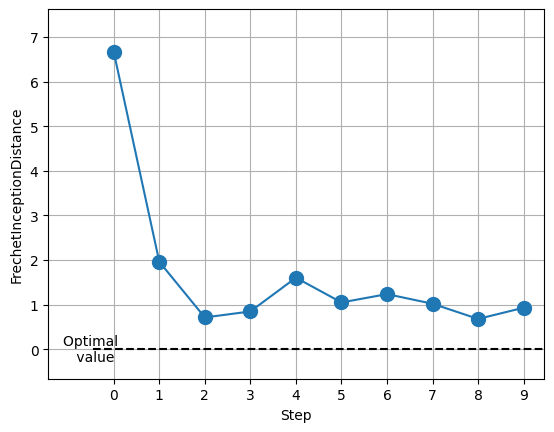

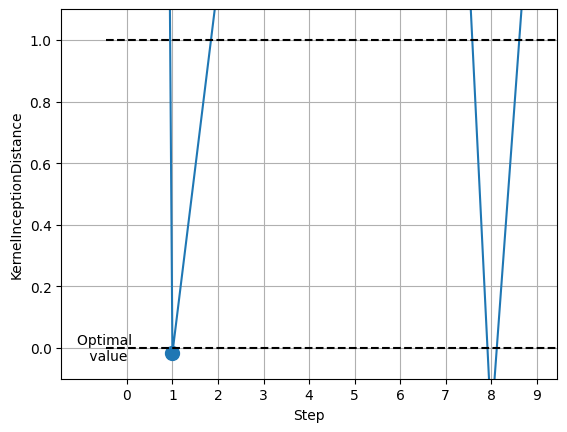

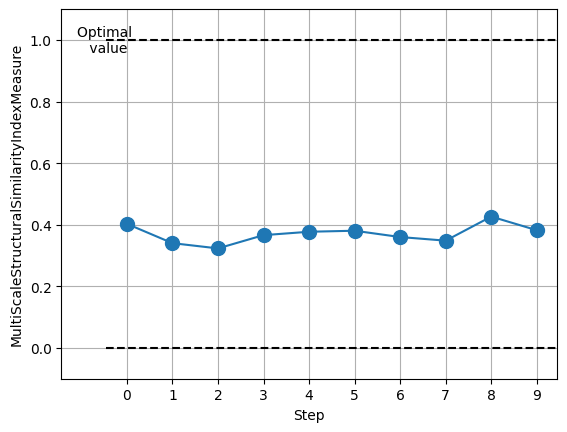

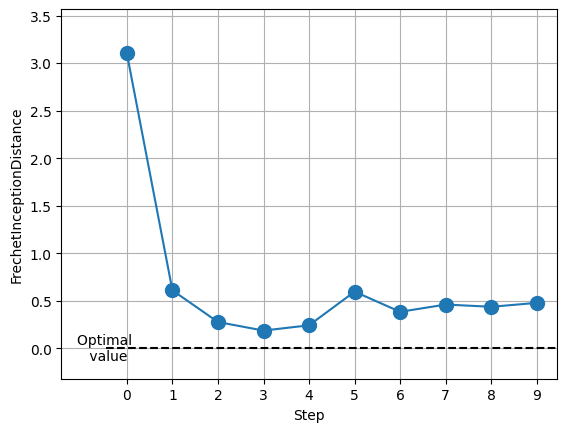

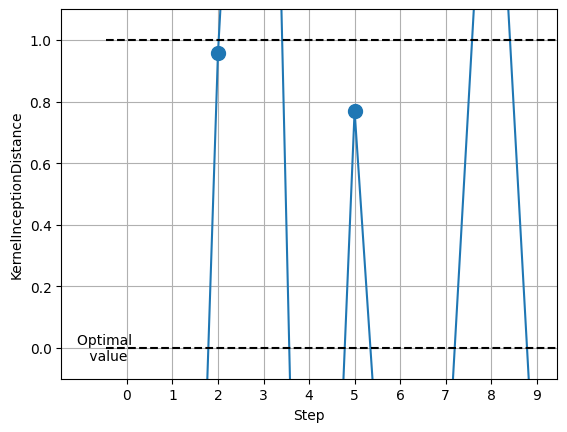

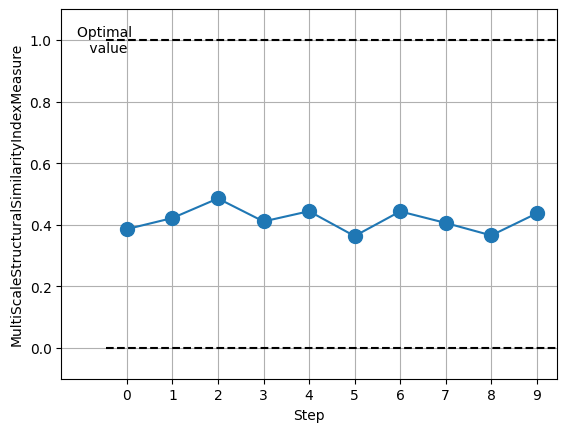

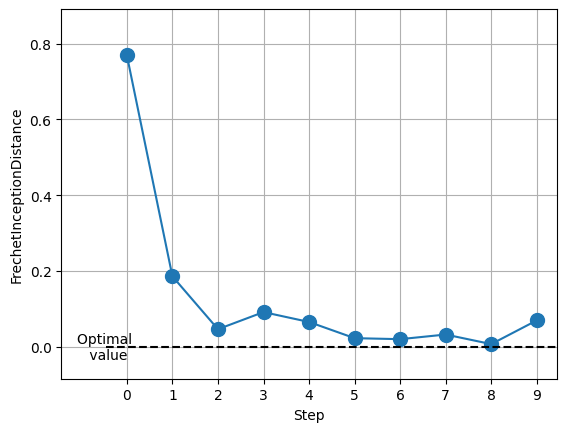

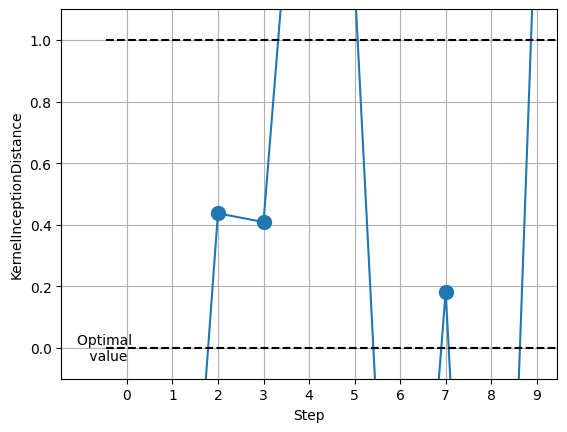

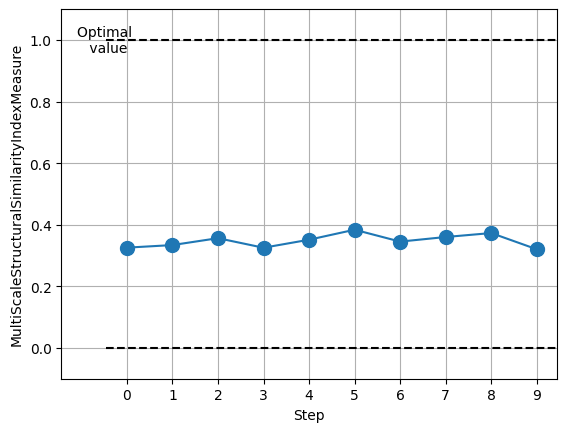

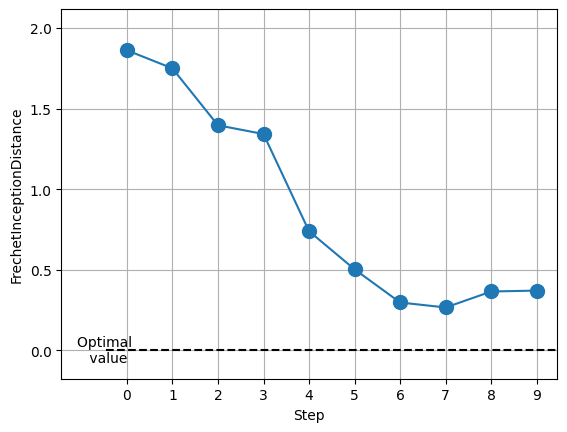

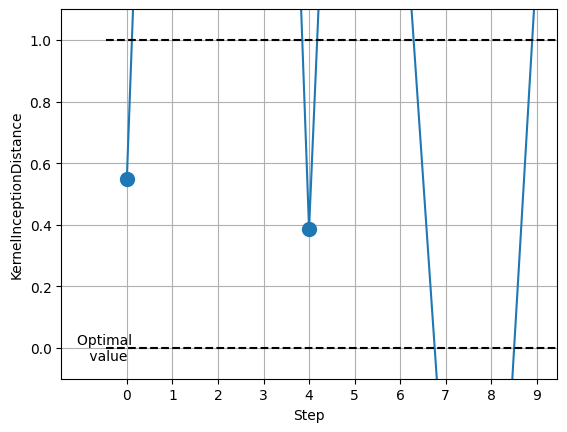

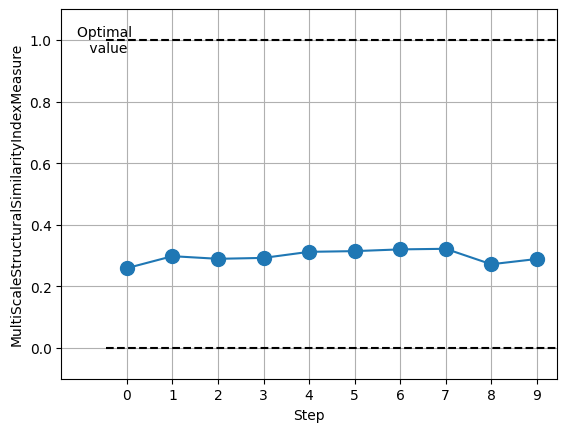

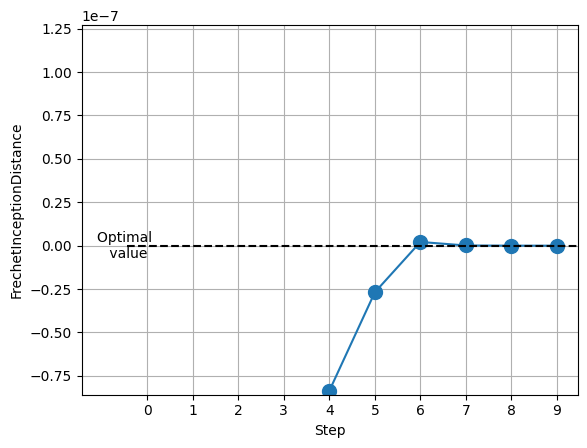

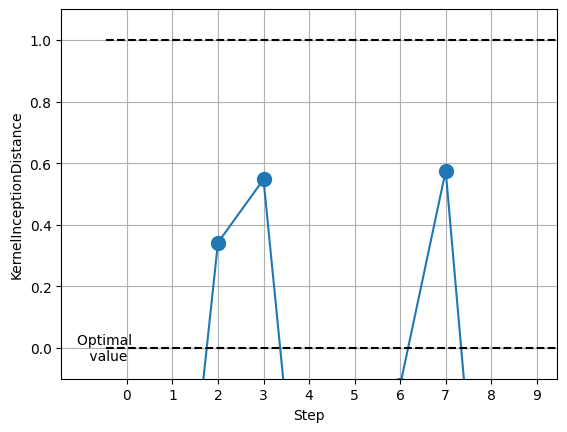

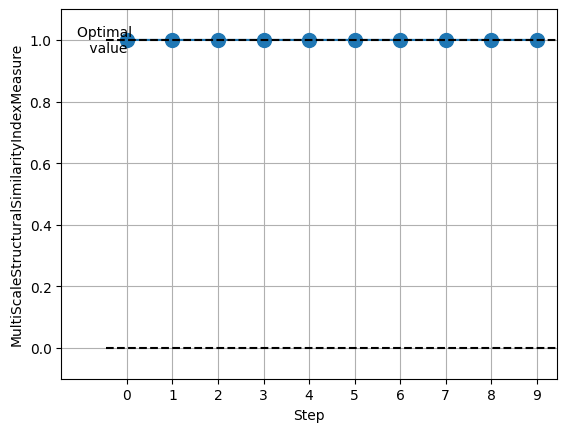

In [ ]:
# Procesar
dCSV = {}
vFid, vKid, vSim, vCant = [], [], [], []
for s in EVENTO_ESTUDIO:
  # Obtener lista de archivos de directorio
  lFileR = list(map(os.path.basename, glob.glob('spectrograms224/'+s+'/'+"*.*")))
  lFileF = list(map(os.path.basename, glob.glob('spectrograms224_00/'+s+'/'+"*.*")))

  # Cargar magen a array de tensores
  imgReal = LoadImgTensor(lFileR, 'spectrograms224/'+s+'/')
  imgFake = LoadImgTensor(lFileF, 'spectrograms224_00/'+s+'/')

  # Calcula métrica
  fid, _ = FID(imgReal[:100,:,:,:], imgFake[:100,:,:,:], batchsize=10, showPlot=True)
  vFid.append(fid)
  kid, _ = KID(imgReal[:100,:,:,:], imgFake[:100,:,:,:], batchsize=10, showPlot=True)
  vKid.append(kid)
  sim, _ = MSSSIM(imgReal[:100,:,:,:]/255, imgFake[:100,:,:,:]/255, 10, True)
  vSim.append(sim)
  vCant.append(imgReal.shape[0]+imgFake.shape[0])
  print(s, 'FID:', fid, '\t', 'KID:', kid, '\t', 'MSSSIM:', sim, '\t', list(imgReal.shape), '+', list(imgFake.shape), '=', imgReal.shape[0]+imgFake.shape[0])
  dCSV[s]=(imgReal.shape[0], imgFake.shape[0], fid, kid, sim)
# Promedio/Promedio ponderado
print('FID Promedio/Ponderado:', sum(vFid)/len(vFid), sum(list(map(lambda x,y : x*y, vFid, vCant)))/sum(vCant))
print('KID Promedio/Ponderado:', sum(vKid)/len(vKid), sum(list(map(lambda x,y : x*y, vKid, vCant)))/sum(vCant))
print('FID Promedio/Ponderado:', sum(vSim)/len(vSim), sum(list(map(lambda x,y : x*y, vSim, vCant)))/sum(vCant))
# Creando CSV
'''with open('Resultados.csv', mode='w') as csvfile:
  csv_wrt = csv.writer(csvfile, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  csv_wrt.writerow(['Archivo','Real','Real','Real','Real','Fake','Fake','Fake','Fake','HY','LP','TC','TR','Fid','FidP'])
  csv_wrt.writerow(['Archivo',
                    dCSV['HY'][0], dCSV['LP'][0], dCSV['TC'][0], dCSV['TR'][0],
                    dCSV['HY'][1], dCSV['LP'][1], dCSV['TC'][1], dCSV['TR'][1],
                    dCSV['HY'][2], dCSV['LP'][2], dCSV['TC'][2], dCSV['TR'][2],
                    sum(vFid)/len(vFid), sum(list(map(lambda x,y : x*y, vFid, vCant)))/sum(vCant)
                  ]) '''

### Múltiple

In [ ]:
# Parametros
EVENTO_ESTUDIO = ['HY','LP','TC','TR','VT'] # Eventos estudio a procesarse
lArchivos =[
  #'spectrograms224_00 231211 20Hz+da_ag 5_3.zip',
  #'spectrograms224_00 231211 20Hz+da_ag 5_3 artificial.zip',
  #'spectrograms224_00 231211 20Hz+da_ag 5_5.zip',
  #'spectrograms224_00 231211 20Hz+da_ag 5_5 artificial.zip',
  'spectrograms224_00 231211 20Hz+da_ag1 0.4_10T.zip',
  'spectrograms224_00 231211 20Hz+da_ag1 0.4_10T artificial.zip',
  'spectrograms224_00 231211 20Hz+da_ag1 0.45_10T.zip',
  'spectrograms224_00 231211 20Hz+da_ag1 0.45_10T artificial.zip'
]                                           # Archivos de proceso
lArchivos

['spectrograms224_00 231211 20Hz+da_ag1 0.4_10T.zip',
 'spectrograms224_00 231211 20Hz+da_ag1 0.4_10T artificial.zip',
 'spectrograms224_00 231211 20Hz+da_ag1 0.45_10T.zip',
 'spectrograms224_00 231211 20Hz+da_ag1 0.45_10T artificial.zip']

In [ ]:
# Inicio CSV
with open('Resultados.csv', mode='w') as csvfile:
  csv_wrt = csv.writer(csvfile, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  csv_wrt.writerow(['Archivo',
                    'Real','Real','Real','Real','Real',
                    'Fake','Fake','Fake','Fake','Fake',
                    'HY','LP','TC','TR','VT','Sim','SimP'])

  # Procesando archivos
  for archivo in lArchivos:
    # Eliminar carpeta de espectrogramas de trabajo
    !rm -rf spectrograms224_00
    # Descomprimirlo archivo comprimido
    !unzip {'"'+archivo+'"'} &> /dev/null
    # Proceso eventos
    dCSV = {}
    vSim, vCant = [], []
    for s in EVENTO_ESTUDIO:
      # Obtener lista de archivos de directorio
      lFileR = list(map(os.path.basename, glob.glob('spectrograms224/'+s+'/'+"*.*")))
      lFileF = list(map(os.path.basename, glob.glob('spectrograms224_00/'+s+'/'+"*.*")))

      # Cargar magen a array de tensores
      imgReal = LoadImgTensor(lFileR, 'spectrograms224/'+s+'/')
      imgFake = LoadImgTensor(lFileF, 'spectrograms224_00/'+s+'/')

      # Calcula métricas
      sim, _ = MSSSIM(imgReal/255, imgFake/255)
      vSim.append(sim)
      vCant.append(imgReal.shape[0]+imgFake.shape[0])
      print(s, 'MSSSIM:', sim, '\t', list(imgReal.shape), '+', list(imgFake.shape), '=', imgReal.shape[0]+imgFake.shape[0])
      dCSV[s]=(imgReal.shape[0], imgFake.shape[0], sim)
    # Promedio/Promedio ponderado
    print('MS-SSIM Promedio/Ponderado:', sum(vSim)/len(vSim), sum(list(map(lambda x,y : x*y, vSim, vCant)))/sum(vCant))
    # Creando CSV
    csv_wrt.writerow([archivo,
      dCSV['HY'][0], dCSV['LP'][0], dCSV['TC'][0], dCSV['TR'][0], dCSV['VT'][0],
      dCSV['HY'][1], dCSV['LP'][1], dCSV['TC'][1], dCSV['TR'][1], dCSV['VT'][1],
      dCSV['HY'][2], dCSV['LP'][2], dCSV['TC'][2], dCSV['TR'][2], dCSV['VT'][2],
      sum(vSim)/len(vSim), sum(list(map(lambda x,y : x*y, vSim, vCant)))/sum(vCant)
    ])
# Descarga automática
files.download('Resultados.csv')

HY MSSSIM: 0.34971112 	 [213, 3, 224, 224] + [2686, 3, 224, 224] = 2899
LP MSSSIM: 0.39961684 	 [577, 3, 224, 224] + [2686, 3, 224, 224] = 3263
TC MSSSIM: 0.32475847 	 [2198, 3, 224, 224] + [2686, 3, 224, 224] = 4884
TR MSSSIM: 0.2961073 	 [471, 3, 224, 224] + [2686, 3, 224, 224] = 3157
VT MSSSIM: 0.99999994 	 [2686, 3, 224, 224] + [2686, 3, 224, 224] = 5372
MS-SSIM Promedio/Ponderado: 0.47403875 0.5216191
HY MSSSIM: 0.37215674 	 [213, 3, 224, 224] + [2686, 3, 224, 224] = 2899
LP MSSSIM: 0.39551306 	 [577, 3, 224, 224] + [2686, 3, 224, 224] = 3263
TC MSSSIM: 0.33076683 	 [2198, 3, 224, 224] + [2686, 3, 224, 224] = 4884
TR MSSSIM: 0.29704076 	 [471, 3, 224, 224] + [2686, 3, 224, 224] = 3157
VT MSSSIM: 0.33614272 	 [2686, 3, 224, 224] + [2686, 3, 224, 224] = 5372
MS-SSIM Promedio/Ponderado: 0.34632403 0.34372532
HY MSSSIM: 0.3621085 	 [213, 3, 224, 224] + [2686, 3, 224, 224] = 2899
LP MSSSIM: 0.40342247 	 [577, 3, 224, 224] + [2686, 3, 224, 224] = 3263
TC MSSSIM: 0.3316681 	 [2198, 3, 22

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lArchivos =[
  'spectrograms224_00 210708 20Hz.zip',
  'spectrograms224_00.05-25_20Hz.zip',
  'spectrograms224_00.05-25_20Hz 13430 Artificial.zip',
  'spectrograms224_00 210708 20Hz+da_jittering 0.2 real+artificial.zip',
  'spectrograms224_00 210708 20Hz+da_jittering 0.2 artificial.zip',
  'spectrograms224_00 210708 20Hz+da_drifting 0.01-0.1.zip',
  'spectrograms224_00 210708 20Hz+da_drifting 0.01-0.1 13430 Artificial.zip',
  'spectrograms224_00 210708 20Hz+da_drifting 0.001-0.01.zip',
  'spectrograms224_00 210708 20Hz+da_drifting 0.001-0.01 13430 Artificial.zip',
  'spectrograms224_00 210708 20Hz+da_drifting 0.0001-0.001.zip',
  'spectrograms224_00 210708 20Hz+da_drifting 0.0001-0.001 13430 Artificial.zip',
  'spectrograms224_00 231211 20Hz+da_ag 5_3.zip',
  'spectrograms224_00 231211 20Hz+da_ag 5_3 artificial.zip',
  'spectrograms224_00 231211 20Hz+da_ag 5_5.zip',
  'spectrograms224_00 231211 20Hz+da_ag 5_5 artificial.zip',
  'spectrograms224_00 231211 20Hz+da_ag1 0.4_10T.zip',
  'spectrograms224_00 231211 20Hz+da_ag1 0.4_10T artificial.zip',
  'spectrograms224_00 231211 20Hz+da_ag1 0.45_10T.zip',
  'spectrograms224_00 231211 20Hz+da_ag1 0.45_10T artificial.zip',
  'spectrograms224_00 231211 20Hz+da_sa 0.1-2 0.1-2.zip',
  'spectrograms224_00 231211 20Hz+da_sa 0.1-2 0.1-2 artificial.zip',
  'spectrograms224_00 231211 20Hz+da_sa 0.15-2 0.15-2.zip',
  'spectrograms224_00 231211 20Hz+da_sa 0.15-2 0.15-2 artificial.zip',
  'spectrograms224_00 231218 20Hz+da_interpolation 40-60.zip',
  'spectrograms224_00 231218 20Hz+da_interpolation 40-60 artificial.zip'
]
lArchivos

['spectrograms224_00 210708 20Hz.zip',
 'spectrograms224_00.05-25_20Hz.zip',
 'spectrograms224_00.05-25_20Hz 13430 Artificial.zip',
 'spectrograms224_00 210708 20Hz+da_jittering 0.2 real+artificial.zip',
 'spectrograms224_00 210708 20Hz+da_jittering 0.2 artificial.zip',
 'spectrograms224_00 210708 20Hz+da_drifting 0.01-0.1.zip',
 'spectrograms224_00 210708 20Hz+da_drifting 0.01-0.1 13430 Artificial.zip',
 'spectrograms224_00 210708 20Hz+da_drifting 0.001-0.01.zip',
 'spectrograms224_00 210708 20Hz+da_drifting 0.001-0.01 13430 Artificial.zip',
 'spectrograms224_00 210708 20Hz+da_drifting 0.0001-0.001.zip',
 'spectrograms224_00 210708 20Hz+da_drifting 0.0001-0.001 13430 Artificial.zip',
 'spectrograms224_00 231211 20Hz+da_ag 5_3.zip',
 'spectrograms224_00 231211 20Hz+da_ag 5_3 artificial.zip',
 'spectrograms224_00 231211 20Hz+da_ag 5_5.zip',
 'spectrograms224_00 231211 20Hz+da_ag 5_5 artificial.zip',
 'spectrograms224_00 231211 20Hz+da_ag1 0.4_10T.zip',
 'spectrograms224_00 231211 20Hz+d